In [193]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams['xtick.labelsize'] = '16'
plt.rcParams['ytick.labelsize'] = '16'
plt.rcParams['axes.labelsize'] = '18'
plt.rcParams['axes.titlesize'] = '18'

cat = pd.read_csv('animal_observations.csv')
clean_mask = np.isfinite(cat['body mass']) & np.isfinite(cat['brain size'])
cat = cat[clean_mask]

# Dealing with data with huge ranges in variables

Today, we're going to step away from sports for a bit and think a bit about some data (like your galaxy zoo catalog) that will require us to worry about both really big and really small things, at least relative to one another. Before we get into the math, let's take a look at what I'm talking about. First, let's see what our catalog looks like:

In [194]:
cat

,phylum,class,order,family,genus,species,specificEpithet,sex,sampleSizeValue,inTextReference,...,mass-specific metabolic rate - units,brain size,brain size - units,brain size - minimum,brain size - maximum,brain size - method,brain size - comments,brain size - metadata comment,original brain size,original brain size - units
0,Chordata,Amphibia,Anura,Hylidae,Hyla,Hyla versicolor,versicolor,NaN,1,"Taylor, Nol, & Boire, 1995",...,NaN,0.000042,kg,NaN,NaN,histological reconstruction,total brain volume,photographs of cross sections were taken and v...,40.79,mm3
1,Chordata,Amphibia,Anura,Hylidae,Pseudacris,Pseudacris triseriata,triseriata,NaN,3,"Taylor, Nol, & Boire, 1995",...,NaN,0.000002,kg,NaN,NaN,histological reconstruction,NaN,photographs of cross sections were taken and v...,2.18,mm3
2,Chordata,Amphibia,Anura,Hylidae,Acris,Acris crepitans,crepitans,NaN,3,"Taylor, Nol, & Boire, 1995",...,NaN,0.000004,kg,NaN,NaN,histological reconstruction,NaN,photographs of cross sections were taken and v...,4.28,mm3
3,Chordata,Amphibia,Anura,Ceratobatrachidae,Platymantis,Platymantis vitiensis,vitiensis,NaN,1,"Taylor, Nol, & Boire, 1995",...,NaN,0.000005,kg,NaN,NaN,histological reconstruction,NaN,photographs of cross sections were taken and v...,4.76,mm3
4,Chordata,Amphibia,Anura,Ranidae,Rana,Rana sylvatica,sylvatica,NaN,3,"Taylor, Nol, & Boire, 1995",...,NaN,0.000009,kg,NaN,NaN,histological reconstruction,NaN,photographs of cross sections were taken and v...,8.27,mm3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2306,Chordata,Reptilia,Squamata,Agamidae,Ctenophorus,Ctenophorus pictus,pictus,NaN,28,"Hoops et al., 2017",...,NaN,0.000084,kg,NaN,NaN,histological reconstruction,NaN,magnetic resonance imaging of whole brain,1259516.00,x6.4e-5 mm3
2307,Chordata,Reptilia,Squamata,Agamidae,Ctenophorus,Ctenophorus rufescens,rufescens,NaN,20,"Hoops et al., 2017",...,NaN,0.000120,kg,NaN,NaN,histological reconstruction,NaN,magnetic resonance imaging of whole brain,1814748.00,x6.4e-5 mm3
2308,Chordata,Reptilia,Squamata,Agamidae,Ctenophorus,Ctenophorus salinarum,salinarum,NaN,20,"Hoops et al., 2017",...,NaN,0.000083,kg,NaN,NaN,histological reconstruction,NaN,magnetic resonance imaging of whole brain,1258656.00,x6.4e-5 mm3
2309,Chordata,Reptilia,Squamata,Agamidae,Ctenophorus,Ctenophorus tjantjalka,tjantjalka,NaN,19,"Hoops et al., 2017",...,NaN,0.000094,kg,NaN,NaN,histological reconstruction,NaN,magnetic resonance imaging of whole brain,1424184.00,x6.4e-5 mm3


In [195]:
cat.columns.values

array(['phylum', 'class', 'order', 'family', 'genus', 'species',
       'specificEpithet', 'sex', 'sampleSizeValue', 'inTextReference',
       'publicationYear', 'fullReference', 'body mass',
       'body mass - units', 'body mass - minimum', 'body mass - maximum',
       'body mass - method', 'body mass - comments',
       'body mass - metadata comment', 'original body mass',
       'original body mass - units', 'metabolic rate',
       'metabolic rate - units', 'metabolic rate - minimum',
       'metabolic rate - maximum', 'metabolic rate - method',
       'metabolic rate - comments', 'metabolic rate - metadata comment',
       'original metabolic rate', 'original metabolic rate - units',
       'original respiratoryQuotient', 'original temperature',
       'mass-specific metabolic rate',
       'mass-specific metabolic rate - units', 'brain size',
       'brain size - units', 'brain size - minimum',
       'brain size - maximum', 'brain size - method',
       'brain size - comments'

To get an idea of why we're going to need to be creative, let's take a look at the minimum and maximum of the "body mass" column (which is stored in kilograms).

In [196]:
np.min(cat['body mass']), np.max(cat['body mass'])

(4.4e-08, 759.0)

So the smallest animal in our catalog is $4.94 \times 10^{-9}$ kg, and the largest is $7.59 \times 10^{2}$ kg--11 orders of magnitude. Let's review what we've done before and see what the largest and smallest animals are.

In [197]:
cat.sort_values(['body mass'])

,phylum,class,order,family,genus,species,specificEpithet,sex,sampleSizeValue,inTextReference,...,mass-specific metabolic rate - units,brain size,brain size - units,brain size - minimum,brain size - maximum,brain size - method,brain size - comments,brain size - metadata comment,original brain size,original brain size - units
1253,Arthropoda,Insecta,Hymenoptera,Formicidae,Brachymyrmex,Brachymyrmex sp.1,sp.1,NaN,3,"Seid, Castillo, & Wcislo, 2011",...,NaN,6.000000e-09,kg,NaN,NaN,histological reconstruction,species name corrected,"cross sections were photographed, reconstructe...",0.006,mg
1229,Arthropoda,Insecta,Hymenoptera,Formicidae,Monomorium,Monomorium floricola,floricola,NaN,1,"Seid, Castillo, & Wcislo, 2011",...,NaN,6.000000e-09,kg,NaN,NaN,histological reconstruction,NaN,"cross sections were photographed, reconstructe...",0.006,mg
1234,Arthropoda,Insecta,Hymenoptera,Formicidae,Pheidole,Pheidole sp.3,sp.3,NaN,1,"Seid, Castillo, & Wcislo, 2011",...,NaN,8.000000e-09,kg,NaN,NaN,histological reconstruction,species name corrected,"cross sections were photographed, reconstructe...",0.008,mg
1254,Arthropoda,Insecta,Hymenoptera,Formicidae,Brachymyrmex,Brachymyrmex sp.2,sp.2,NaN,3,"Seid, Castillo, & Wcislo, 2011",...,NaN,6.000000e-09,kg,NaN,NaN,histological reconstruction,species name corrected,"cross sections were photographed, reconstructe...",0.006,mg
1232,Arthropoda,Insecta,Hymenoptera,Formicidae,Pheidole,Pheidole sp.1,sp.1,NaN,1,"Seid, Castillo, & Wcislo, 2011",...,NaN,8.000000e-09,kg,NaN,NaN,histological reconstruction,species name corrected,"cross sections were photographed, reconstructe...",0.008,mg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1472,Chordata,Mammalia,Cetartiodactyla,Bovidae,Tragelaphus,Tragelaphus eurycerus,eurycerus,NaN,1,"Boddy et al., 2012",...,NaN,3.890000e-01,kg,NaN,NaN,NaN,family name from The mammal species of the world,NaN,389.000,g
2043,Chordata,Mammalia,Carnivora,Ursidae,Ursus,Ursus maritimus,maritimus,female,1,"Crile & Quiring, 1940",...,NaN,5.070000e-01,kg,NaN,NaN,brain weighed,NaN,NaN,507.000,g
2272,Chordata,Mammalia,Artiodactyla,Bovidae,Syncerus,Syncerus caffer,caffer,female,1,"Crile & Quiring, 1940",...,NaN,6.420000e-01,kg,NaN,NaN,brain weighed,NaN,NaN,642.000,g
2271,Chordata,Mammalia,Artiodactyla,Bovidae,Syncerus,Syncerus caffer,caffer,male,2,"Crile & Quiring, 1940",...,NaN,6.400000e-01,kg,NaN,NaN,brain weighed,NaN,NaN,640.000,g


In [198]:
cat.sort_values(['body mass'], ascending=False)

,phylum,class,order,family,genus,species,specificEpithet,sex,sampleSizeValue,inTextReference,...,mass-specific metabolic rate - units,brain size,brain size - units,brain size - minimum,brain size - maximum,brain size - method,brain size - comments,brain size - metadata comment,original brain size,original brain size - units
2273,Chordata,Mammalia,Artiodactyla,Bovidae,Syncerus,Syncerus caffer,caffer,male,1,"Crile & Quiring, 1940",...,NaN,6.530000e-01,kg,NaN,NaN,brain weighed,NaN,NaN,653.000,g
2271,Chordata,Mammalia,Artiodactyla,Bovidae,Syncerus,Syncerus caffer,caffer,male,2,"Crile & Quiring, 1940",...,NaN,6.400000e-01,kg,NaN,NaN,brain weighed,NaN,NaN,640.000,g
2272,Chordata,Mammalia,Artiodactyla,Bovidae,Syncerus,Syncerus caffer,caffer,female,1,"Crile & Quiring, 1940",...,NaN,6.420000e-01,kg,NaN,NaN,brain weighed,NaN,NaN,642.000,g
2043,Chordata,Mammalia,Carnivora,Ursidae,Ursus,Ursus maritimus,maritimus,female,1,"Crile & Quiring, 1940",...,NaN,5.070000e-01,kg,NaN,NaN,brain weighed,NaN,NaN,507.000,g
1472,Chordata,Mammalia,Cetartiodactyla,Bovidae,Tragelaphus,Tragelaphus eurycerus,eurycerus,NaN,1,"Boddy et al., 2012",...,NaN,3.890000e-01,kg,NaN,NaN,NaN,family name from The mammal species of the world,NaN,389.000,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1232,Arthropoda,Insecta,Hymenoptera,Formicidae,Pheidole,Pheidole sp.1,sp.1,NaN,1,"Seid, Castillo, & Wcislo, 2011",...,NaN,8.000000e-09,kg,NaN,NaN,histological reconstruction,species name corrected,"cross sections were photographed, reconstructe...",0.008,mg
1254,Arthropoda,Insecta,Hymenoptera,Formicidae,Brachymyrmex,Brachymyrmex sp.2,sp.2,NaN,3,"Seid, Castillo, & Wcislo, 2011",...,NaN,6.000000e-09,kg,NaN,NaN,histological reconstruction,species name corrected,"cross sections were photographed, reconstructe...",0.006,mg
1234,Arthropoda,Insecta,Hymenoptera,Formicidae,Pheidole,Pheidole sp.3,sp.3,NaN,1,"Seid, Castillo, & Wcislo, 2011",...,NaN,8.000000e-09,kg,NaN,NaN,histological reconstruction,species name corrected,"cross sections were photographed, reconstructe...",0.008,mg
1229,Arthropoda,Insecta,Hymenoptera,Formicidae,Monomorium,Monomorium floricola,floricola,NaN,1,"Seid, Castillo, & Wcislo, 2011",...,NaN,6.000000e-09,kg,NaN,NaN,histological reconstruction,NaN,"cross sections were photographed, reconstructe...",0.006,mg


Let's take a look at another variable of interest in here--brain size (also in kg):

In [199]:
np.min(cat['brain size']), np.max(cat['brain size'])

(4.0404e-09, 1.57)

Now we're talking about 25 orders of magnitude, just a huge spread. Same deal as before, let's find the smallest and biggest brained animals:

In [200]:
cat.sort_values('brain size')

,phylum,class,order,family,genus,species,specificEpithet,sex,sampleSizeValue,inTextReference,...,mass-specific metabolic rate - units,brain size,brain size - units,brain size - minimum,brain size - maximum,brain size - method,brain size - comments,brain size - metadata comment,original brain size,original brain size - units
15,Arthropoda,Arachnida,Araneae,Mysmenidae,Mysmena,Mysmena sp.,sp.,female,1,"Quesada et al., 2011",...,NaN,4.040400e-09,kg,NaN,NaN,histological reconstruction,CNS (includes volume of neuropil),photographs of cross sections were taken and t...,3.900,x1e6 um3
1254,Arthropoda,Insecta,Hymenoptera,Formicidae,Brachymyrmex,Brachymyrmex sp.2,sp.2,NaN,3,"Seid, Castillo, & Wcislo, 2011",...,NaN,6.000000e-09,kg,NaN,NaN,histological reconstruction,species name corrected,"cross sections were photographed, reconstructe...",0.006,mg
1253,Arthropoda,Insecta,Hymenoptera,Formicidae,Brachymyrmex,Brachymyrmex sp.1,sp.1,NaN,3,"Seid, Castillo, & Wcislo, 2011",...,NaN,6.000000e-09,kg,NaN,NaN,histological reconstruction,species name corrected,"cross sections were photographed, reconstructe...",0.006,mg
1229,Arthropoda,Insecta,Hymenoptera,Formicidae,Monomorium,Monomorium floricola,floricola,NaN,1,"Seid, Castillo, & Wcislo, 2011",...,NaN,6.000000e-09,kg,NaN,NaN,histological reconstruction,NaN,"cross sections were photographed, reconstructe...",0.006,mg
1244,Arthropoda,Insecta,Hymenoptera,Formicidae,Wasmannia,Wasmannia aurpunctata,aurpunctata,NaN,1,"Seid, Castillo, & Wcislo, 2011",...,NaN,7.000000e-09,kg,NaN,NaN,histological reconstruction,NaN,"cross sections were photographed, reconstructe...",0.007,mg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2180,Chordata,Mammalia,Primates,Hominidae,Homo,Homo sapiens,sapiens,male,1,"Crile & Quiring, 1940",...,NaN,1.480000e+00,kg,NaN,NaN,brain weighed,NaN,NaN,1480.000,g
2173,Chordata,Mammalia,Primates,Hominidae,Homo,Homo sapiens,sapiens,male,1,"Crile & Quiring, 1940",...,NaN,1.490000e+00,kg,NaN,NaN,brain weighed,NaN,NaN,1490.000,g
2170,Chordata,Mammalia,Primates,Hominidae,Homo,Homo sapiens,sapiens,male,1,"Crile & Quiring, 1940",...,NaN,1.500000e+00,kg,NaN,NaN,brain weighed,NaN,NaN,1500.000,g
2161,Chordata,Mammalia,Primates,Hominidae,Homo,Homo sapiens,sapiens,male,1,"Crile & Quiring, 1940",...,NaN,1.540000e+00,kg,NaN,NaN,brain weighed,NaN,NaN,1540.000,g


In [201]:
cat.sort_values('brain size', ascending=False)

,phylum,class,order,family,genus,species,specificEpithet,sex,sampleSizeValue,inTextReference,...,mass-specific metabolic rate - units,brain size,brain size - units,brain size - minimum,brain size - maximum,brain size - method,brain size - comments,brain size - metadata comment,original brain size,original brain size - units
2172,Chordata,Mammalia,Primates,Hominidae,Homo,Homo sapiens,sapiens,male,1,"Crile & Quiring, 1940",...,NaN,1.570000e+00,kg,NaN,NaN,brain weighed,NaN,NaN,1570.000,g
2161,Chordata,Mammalia,Primates,Hominidae,Homo,Homo sapiens,sapiens,male,1,"Crile & Quiring, 1940",...,NaN,1.540000e+00,kg,NaN,NaN,brain weighed,NaN,NaN,1540.000,g
2170,Chordata,Mammalia,Primates,Hominidae,Homo,Homo sapiens,sapiens,male,1,"Crile & Quiring, 1940",...,NaN,1.500000e+00,kg,NaN,NaN,brain weighed,NaN,NaN,1500.000,g
2173,Chordata,Mammalia,Primates,Hominidae,Homo,Homo sapiens,sapiens,male,1,"Crile & Quiring, 1940",...,NaN,1.490000e+00,kg,NaN,NaN,brain weighed,NaN,NaN,1490.000,g
2180,Chordata,Mammalia,Primates,Hominidae,Homo,Homo sapiens,sapiens,male,1,"Crile & Quiring, 1940",...,NaN,1.480000e+00,kg,NaN,NaN,brain weighed,NaN,NaN,1480.000,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244,Arthropoda,Insecta,Hymenoptera,Formicidae,Wasmannia,Wasmannia aurpunctata,aurpunctata,NaN,1,"Seid, Castillo, & Wcislo, 2011",...,NaN,7.000000e-09,kg,NaN,NaN,histological reconstruction,NaN,"cross sections were photographed, reconstructe...",0.007,mg
1254,Arthropoda,Insecta,Hymenoptera,Formicidae,Brachymyrmex,Brachymyrmex sp.2,sp.2,NaN,3,"Seid, Castillo, & Wcislo, 2011",...,NaN,6.000000e-09,kg,NaN,NaN,histological reconstruction,species name corrected,"cross sections were photographed, reconstructe...",0.006,mg
1229,Arthropoda,Insecta,Hymenoptera,Formicidae,Monomorium,Monomorium floricola,floricola,NaN,1,"Seid, Castillo, & Wcislo, 2011",...,NaN,6.000000e-09,kg,NaN,NaN,histological reconstruction,NaN,"cross sections were photographed, reconstructe...",0.006,mg
1253,Arthropoda,Insecta,Hymenoptera,Formicidae,Brachymyrmex,Brachymyrmex sp.1,sp.1,NaN,3,"Seid, Castillo, & Wcislo, 2011",...,NaN,6.000000e-09,kg,NaN,NaN,histological reconstruction,species name corrected,"cross sections were photographed, reconstructe...",0.006,mg


Let's start by making some histograms to show why our previous approach to dealing with this data isn't going to work. Do decide on our bins, let's try just making 50 bins between the minimum and maximum values of our data set for body mass.

Text(0.5, 0, 'Body Mass [kg]')

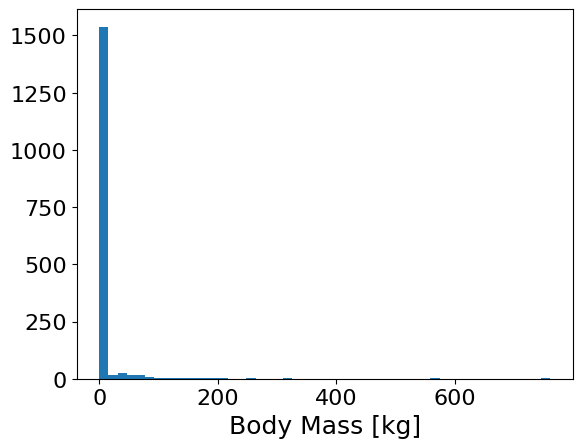

In [202]:
mass_bins = np.linspace(np.min(cat['body mass']), np.max(cat['body mass'])+1, 50)

plt.hist(cat['body mass'], bins=mass_bins)
plt.xlabel('Body Mass [kg]')

Well that's not very informative, right? We can say that almost all of the values are small, but what about how small they really are? We can see this again if we plot the body mass versus brain size for the whole data set.

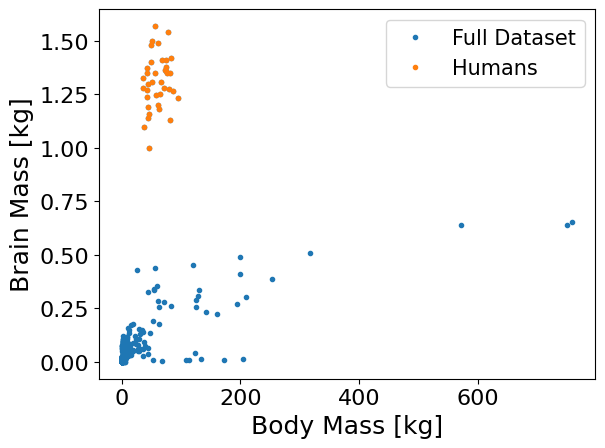

In [203]:
mask = cat['genus'] == 'Homo'

plt.plot(cat['body mass'], cat['brain size'], '.', label='Full Dataset')
plt.plot(cat[mask]['body mass'], cat[mask]['brain size'], '.', label='Humans')
plt.xlabel('Body Mass [kg]')
plt.ylabel('Brain Mass [kg]')
plt.legend(fontsize=15)

But now, let's make the same plot where we make our points way smaller to see where most of the data really is.

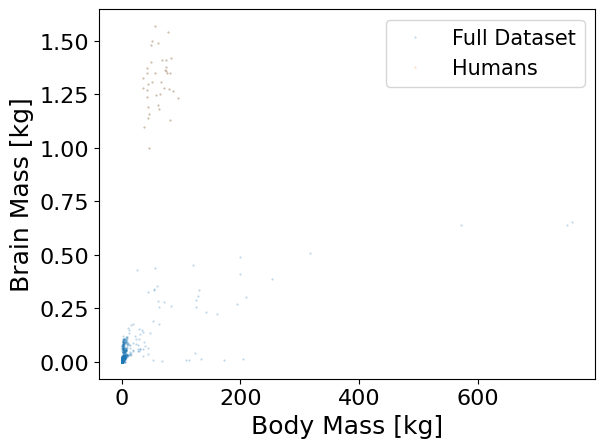

In [204]:
mask = cat['genus'] == 'Homo'

plt.plot(cat['body mass'], cat['brain size'], '.', label='Full Dataset', ms=1, alpha=0.3)
plt.plot(cat[mask]['body mass'], cat[mask]['brain size'], '.', label='Humans', ms=1, alpha=0.3)
plt.xlabel('Body Mass [kg]')
plt.ylabel('Brain Mass [kg]')
plt.legend(fontsize=15)

In order to get a better idea of what this data really looks like, we can make use of logarithms. The logarithm operator basically "pulls down" an exponent. For example:

# $y = x^{5}$

# $\log_{10}(y) = \log_{10}(x^5) = 5 \log_{10}(x)$

The other really useful aspect of a logarithm is that two numbers when multiplied linearly *add* logarithmically:

# $y = a x$

# $\log_{10}(y) = \log_{10}(ax) = \log_{10}(a) + \log_{10}(x)$

The one other important thing to know about logs is that you can reverse them by doing a 10^ operation. For example:

# $10^{\log_{10}(x)} = x$

This simple operation is extremely powerful--it takes data that would be really difficult to understand and puts it on a scale where we can deal with it even with wide ranges in the values. Let's take a look at what this does to body mass below:

In [205]:
log_body_mass = np.log10(cat['body mass'])
cat['log_body_mass'] = log_body_mass

np.min(log_body_mass), np.max(log_body_mass)

(-7.356547323513813, 2.88024177589548)

Now, let's make a histogram.

Text(0.5, 0, '$\\log_{10}$(Body Mass [kg])')

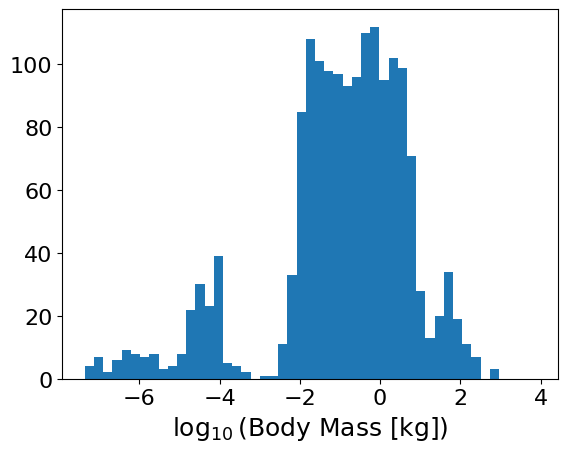

In [206]:
log_body_mass_bins = np.linspace(np.min(cat['log_body_mass']), np.max(cat['log_body_mass'])+1, 50)

plt.hist(log_body_mass, bins=log_body_mass_bins)
plt.xlabel(r'$\log_{10}$(Body Mass [kg])')

Let's take a look at the same thing for brain size.

In [207]:
log_brain_size = np.log10(cat['brain size'])
cat['log_brain_size'] = log_brain_size

np.min(cat['log_brain_size']), np.max(cat['log_brain_size'])

(-8.393575637564286, 0.19589965240923377)

Text(0.5, 0, '$\\log_{10}$(Brain Size [kg])')

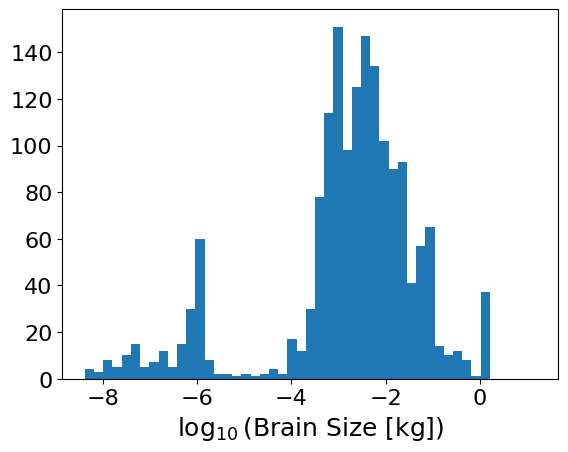

In [208]:
log_brain_size_bins = np.linspace(np.min(cat['log_brain_size']), np.max(cat['log_brain_size'])+1, 50)

plt.hist(cat['log_brain_size'], bins=log_brain_size_bins)
plt.xlabel(r'$\log_{10}$(Brain Size [kg])')

So now we can actually see that most of brain sizes are tiny, but it's actually really rare for them to be so insanely small. To clean things up a bit, let's create a new catalog where we only include animals with brain sizes >$10^{-9}$ kg (1 milligram), and then plot again.

In [209]:
cat_clean = cat.query('log_brain_size>-9')

Text(0.5, 0, '$\\log_{10}$(Brain Size [kg])')

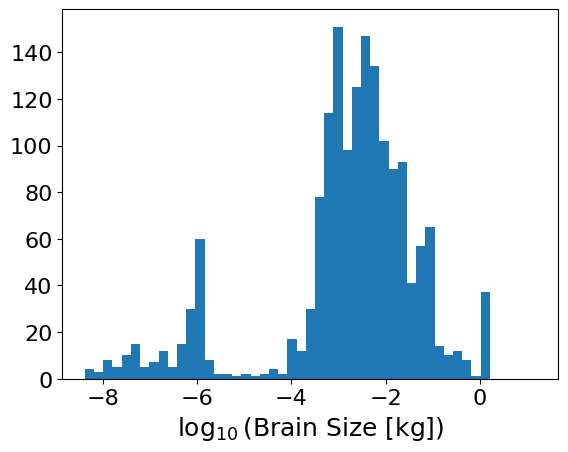

In [210]:
log_brain_size_bins = np.linspace(np.min(cat_clean['log_brain_size']), np.max(cat_clean['log_brain_size'])+1, 50)

plt.hist(cat_clean['log_brain_size'], bins=log_brain_size_bins)
plt.xlabel(r'$\log_{10}$(Brain Size [kg])')

Now, let's use our clean cat to remake our body mass versus brain size diagram.

Text(0.5, 0, '$\\log_{10}$(Body Mass [kg])')

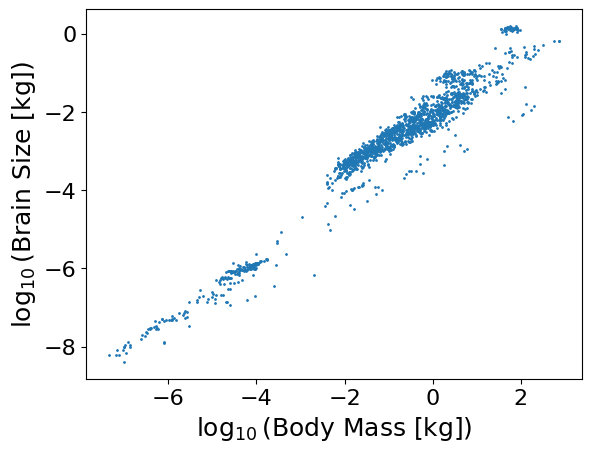

In [211]:
plt.plot(cat_clean['log_body_mass'], cat_clean['log_brain_size'], '.', ms=2)
plt.ylabel(r'$\log_{10}$(Brain Size [kg])')
plt.xlabel(r'$\log_{10}$(Body Mass [kg])')

Now we're cooking, that looks great. We can still see that there are lots of different "clouds" that different species live in. One nice way to visualize data like this along different categories is by plotting each of the different categories as its own colored point. We can do that really easily by looping through the "genus" (one step above species) and see where different groups lie. We can do that like so:

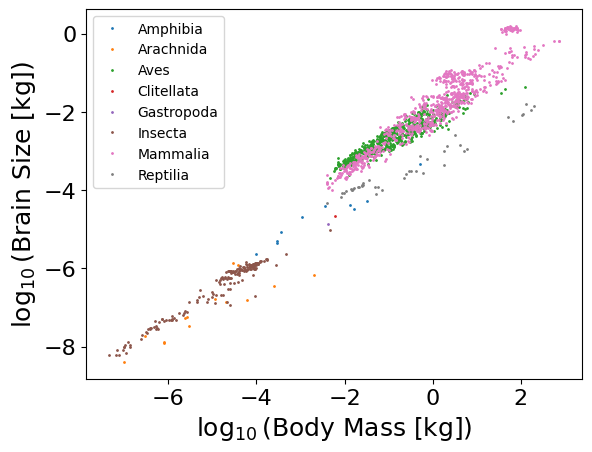

In [212]:
for animal_class in np.unique(cat_clean['class']):
    animal_class_mask = (cat_clean['class']==animal_class)
    cat_animal_class = cat_clean[animal_class_mask]

    plt.plot(cat_animal_class['log_body_mass'], cat_animal_class['log_brain_size'], '.', label=f'{animal_class}', ms=2)

plt.ylabel(r'$\log_{10}$(Brain Size [kg])')
plt.xlabel(r'$\log_{10}$(Body Mass [kg])')
plt.legend()

Let's zoom in on just the top right part of this plot to get a closer look.

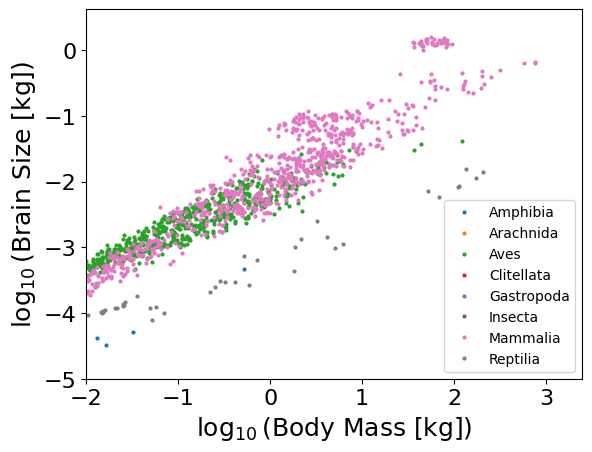

In [213]:
for animal_class in np.unique(cat_clean['class']):
    animal_class_mask = (cat_clean['class']==animal_class)
    cat_animal_class = cat_clean[animal_class_mask]

    plt.plot(cat_animal_class['log_body_mass'], cat_animal_class['log_brain_size'], '.', label=f'{animal_class}', ms=4)

plt.ylabel(r'$\log_{10}$(Brain Size [kg])')
plt.xlabel(r'$\log_{10}$(Body Mass [kg])')
plt.xlim(-2)
plt.ylim(-5)
plt.legend()

The real beauty of logarithms comes into play when we start to think about fitting a functional form known as a "power" law. A power law is any function that takes the form:

# $y = a x^{k}$

where k can be any value we'd like it to be. This is a super broad range of classes of functions, as we'll see below. Play around with the values of a and k for this function and let's see what happens.

Text(0, 0.5, 'y')

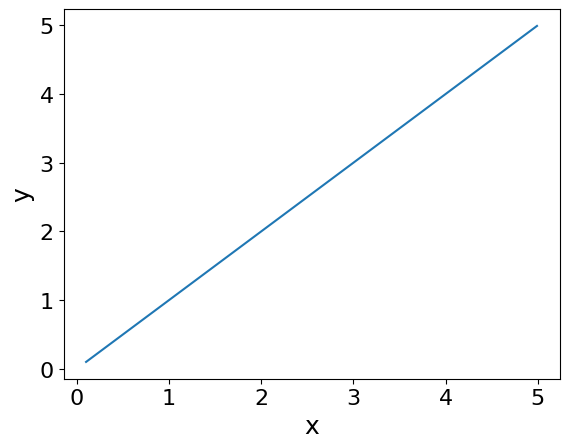

In [214]:
def power_law(x, a, k):
    return a * x**k

a = 1
k = 1

x_arr = np.arange(0.1,5, 0.01)

plt.plot(x_arr, power_law(x_arr, a, k))
plt.xlabel('x')
plt.ylabel('y')

As you can see, there are all kinds of shapes that this function can take. But let's take the logarithm of both sides, so that our function is instead plotted as x versus y:

# $\log_{10}(y) = \log_{10}(ax^{k}) = \log_{10}(x^k) + \log_{10}(a) = k \log_{10}(x) + \log_{10}(a) $

Let's see how our function changes if we take the log of both sides of our expression.

Text(0, 0.5, '$\\log_{10}$(y)')

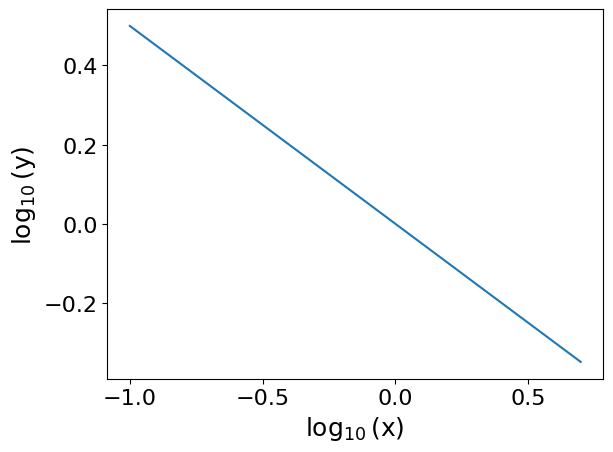

In [215]:
def power_law(x, a, k):
    return a * x**k

a = 1
k = -0.5

x_arr = np.arange(0.1,5, 0.01)

plt.plot(np.log10(x_arr), np.log10(power_law(x_arr, a, k)))
plt.xlabel(r'$\log_{10}$(x)')
plt.ylabel(r'$\log_{10}$(y)')


# A power law, in log space, always looks like a line!

This means that we can easily fit power laws to all kinds of data covering huge ranges of magnitude by just using the same linear regression techniques we covered last time. Let's try applying that to the relationship between the size of birds and their brain sizes.

Text(0, 0.5, 'Brain Mass [kg]')

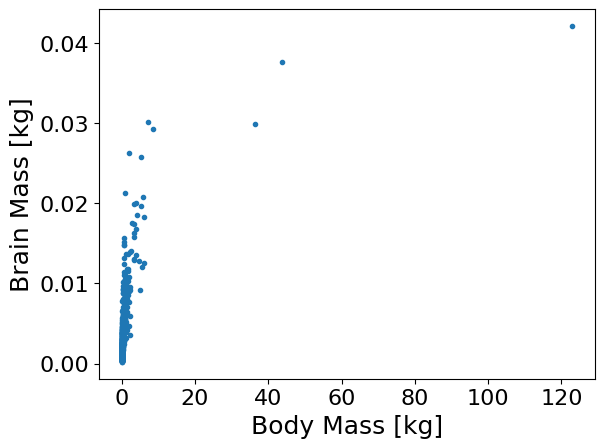

In [234]:
ave_mask = cat['class']=='Aves'

ave_cat = cat[ave_mask]

plt.plot(ave_cat['body mass'], ave_cat['brain size'], '.')
plt.xlabel('Body Mass [kg]')
plt.ylabel('Brain Mass [kg]')


And now let's look in log space instead:

Text(0.5, 0, '$\\log_{10}$(Body Mass [kg])')

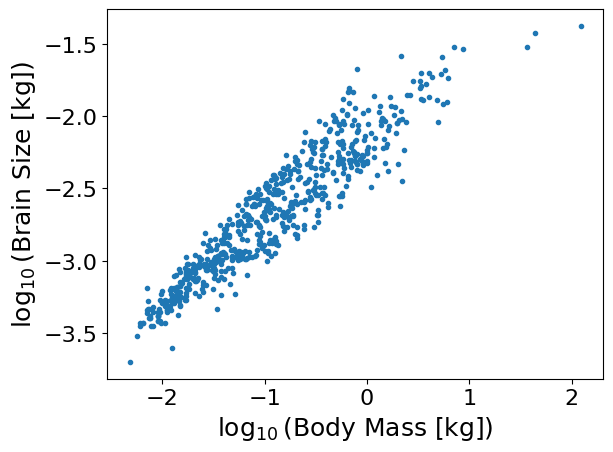

In [235]:
plt.plot(ave_cat['log_body_mass'], ave_cat['log_brain_size'], '.')
plt.ylabel(r'$\log_{10}$(Brain Size [kg])')
plt.xlabel(r'$\log_{10}$(Body Mass [kg])')


In [236]:
from scipy.stats import linregress

fit = linregress(ave_cat['log_body_mass'], ave_cat['log_brain_size'])

fit

LinregressResult(slope=0.5683933438206954, intercept=-2.1425177599302168, rvalue=0.940656736361095, pvalue=4.142749905660755e-302, stderr=0.008111990997401218, intercept_stderr=0.009663942022792424)

Just like before, we got both a slope and an intercept out of our regression... but now they mean something different. Looking again at what happens when we take the log of our power law, this is what our relationship looks like:

# $\log_{10}(\mathrm{Brain \ Size}) = k \log_{10}(\mathrm{Body \ Mass}) + \log_{10}(a)$

So in this case, k is our slope and a is our intercept. So:

# $a = 10^\mathrm{intercept}; k = \mathrm{slope}$

First, let's take a look at our fit in log space:

Text(0.5, 0, '$\\log_{10}$(Body Mass [kg])')

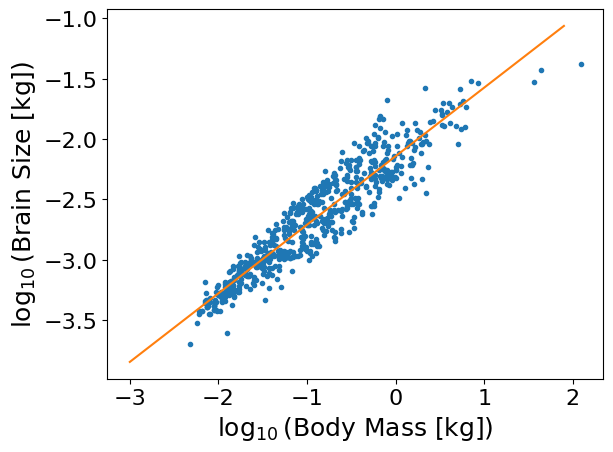

In [237]:
log_body_mass_arr = np.arange(-3, 2, 0.1)

plt.plot(ave_cat['log_body_mass'], ave_cat['log_brain_size'], '.')
plt.plot(log_body_mass_arr, fit.slope * log_body_mass_arr + fit.intercept)
plt.ylabel(r'$\log_{10}$(Brain Size [kg])')
plt.xlabel(r'$\log_{10}$(Body Mass [kg])')


And now, let's instead plot linearly, and plot our power law using our measured quantities.

Text(0, 0.5, 'Brain Mass [kg]')

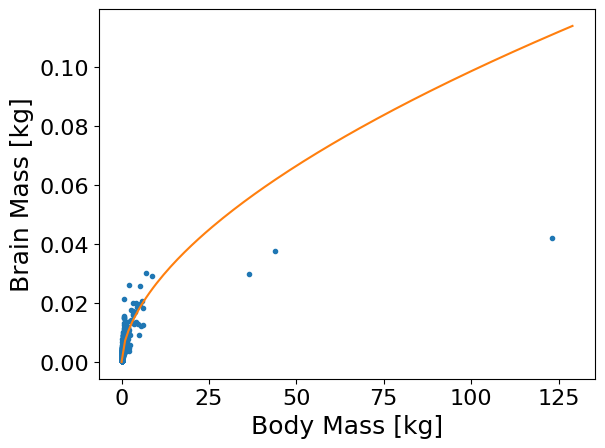

In [239]:
k = fit.slope
a = 10**fit.intercept

body_mass_arr = np.arange(0, 130)

plt.plot(ave_cat['body mass'], ave_cat['brain size'], '.')
plt.plot(body_mass_arr, a * body_mass_arr**k)
plt.xlabel('Body Mass [kg]')
plt.ylabel('Brain Mass [kg]')


So it actually looks like those most massive birds actually have very small brains compared to what the model predicts their brains should look like. What birds are these?

In [ ]:
ave_cat[ave_cat['body_mass']>]

# Activity: go back to the statistics 4 notebook and try to fit a power law to the relation of average shot distance vs field goal percentage. What power law index do you get?